# Batchnorm from Foundations

#### Last Time

In our [previous notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/06_cuda_cnn_hooks_init_my_reimplementation.ipynb?flush_cache=true) we first completed some simple experiments that demonstrated why using GPUs allows deep learning to be practically applied to real-world problems. We then went on to create several PyTorch hooks, and saw how these can be helpful for gaining valuable telemetry on how a model's individual layers behave during training. Finally, we developed a generalized ReLU activation function that offers a few extra knobs, such as setting a max output value, for pracitioners to tweak. We took advantage of this to create a model that reached a validation accuracy score on MNIST that was one percentage point higher than our previous best effort.

#### Batchnorm

Today we take a deep-dive into batch normalization. [Proposed by Ioffe and Szegedy](https://arxiv.org/abs/1502.03167) in 2015, batchnorm's creation was motivated by the goal of being able to train deeper neural networks while enabling a wider, more forgiving range of hyperparameter values. Batchnorm, in a nutshell, is just the process of normalizing layer inputs, on a per-mini-batch basis, during each forward pass that takes place during training. 

More specifically, during the course of training, these moving averages of mean and variance (each layer has its own pair of these moving averages) are used to normalize each layer during each mini-batch, and are updated themselves from one mini-batch to the next.

Once training ends, the moving averages of layer means and variances are *frozen*. And while layer inputs are still normalized during inference, the mean and variance terms used to perform this normalization are *never adjusted*. 

Ioffe and Szegedy demonstrated that batchnorm allowed for the training of deeper networks, at a higher learning rate, while providing enough regularization such that, at times, the need for dropout layers was eliminated. 

Theoretically speaking, the original authors attributed batchnorm's apparent success to its ability to reduce internal covariate shift in the respective distributions of each layer's inputs.

Interestingly, a [recent paper by Santurkar, Tsipras et. al.](https://arxiv.org/abs/1805.11604) demonstrated that far from reducing internal covariate shift among layers' inputs, batchnorm may even increase ICS. Santurkar, Tsipras, et. al. suggested that the reason behind batchnorm's success was that it ultimately makes the optimization landscape (the surface of the loss function) much smoother.

In experiments below, we will demonstrate that batchnorm, nonetheless, is an effective addition to deep neural network architectures. We will also look at alternative approaches, such as layer norm and instance norm. 

We'll wrap up by zero-ing in on batchnorm's one achilles heel, which is that it is often not compatible with small batch-size training. We create a slightly modified alternative, called *Running Batchnorm*, which works around this limitation.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#export
from exports.nb_06 import *

### Preparing the dataset and CNN Model

We continue to forge ahead with more experiments on [MNIST](http://yann.lecun.com/exdb/mnist/). We also use the [same CNN](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/06_cuda_cnn_hooks_init_my_reimplementation.ipynb?flush_cache=true) that we settled upon at the conclusion of our previous notebook.

In [4]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]
# Output sizes for each of our 5 conv layers
n_outs = [8,16,32,64,64] 

learn, run = get_learn_run(n_outs, data, 0.4, conv_layer, cbs=cbfs)

In [5]:
%time run.fit(2, learn)

train: [1.7746859375, tensor(0.4075, device='cuda:0')]
valid: [0.465598291015625, tensor(0.8494, device='cuda:0')]
train: [0.3334828125, tensor(0.8966, device='cuda:0')]
valid: [0.14805205078125, tensor(0.9529, device='cuda:0')]
CPU times: user 4.58 s, sys: 1.71 s, total: 6.29 s
Wall time: 7.82 s


### Batchnorm

#### Building Batchnorm from scratch

Note that in PyTorch, batchnorm momentum is defined in reverse to how we're accustomed. For example, if we want to set momentum to `0.9`, we'd pass a value of `0.1` to the momentum hyperparameter.

Also note how below we register buffers for the `means` and `vars`. Everything we register as a buffer is automatically moved to the GPU if we decide to run our model on the GPU (this wouldn't be the case if we were to use `self.vars` or `self.means` instead).

An additional advantage of registering buffers: if we save our model, we'll have to save the running means and variances. Registering them as buffers allows them to also be saved when we save the whole model.

The [PyTorch `lerp` operation](https://pytorch.org/docs/stable/torch.html#torch.lerp) performs a linear interpolation of two tensors based on a scalar weight: $$\text{out}_{i} = \text{start}_{i} + \text{weight} × (\text{end}_{i} − \text{start}_{i})$$

Because taking an exponentially weighted moving average is more computationally efficient than calculating a plain moving average, we use PyTorch's `lerp` operation to apply our momentum value while updating the moving averages of both the means and the variances for each layer, after each training mini-batch.

In [6]:
class BatchNorm(nn.Module):
    def __init__(self, n_out, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (n_out,1,1))
        self.adds  = nn.Parameter(torch.zeros(n_out,1,1))
        self.register_buffer('vars',   torch.ones(1,n_out,1,1))
        self.register_buffer('means', torch.zeros(1,n_out,1,1))
        
    def update_stats(self, x):
        # Take the mean and variance over dimensions 0, 2, and 3:
        # namely, across the height, and width, over all images in 
        # one mini-batch.
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        # Use lerp to include our momentum value when updating
        # the moving averages of a layer's mean and variance.
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

We reimplement our `conv_layer()` method so that we can have the option of including batchnorm layers. Note that if we include batchnorm after our convolutional layers we don't need to include a bias in these layers.

In [7]:
def conv_layer(n_in, n_out, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(n_out))
    return nn.Sequential(*layers)

In [8]:
#export
def init_cnn_(m, f): # m stands for module, f represents the initialization kind
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(n_outs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, n_outs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

Let's run our model with some forward hooks, so we can verify whether or not batchnorm really helps keep mean and standard deviation of layer activation outputs closer to the ideal values 0 and 1.0, respectively.

In [9]:
learn, run = get_learn_run(n_outs, data, 1.0, conv_layer, cbs=cbfs)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

train: [0.28989546875, tensor(0.9097, device='cuda:0')]
valid: [0.1342404541015625, tensor(0.9604, device='cuda:0')]
train: [0.0932426171875, tensor(0.9712, device='cuda:0')]
valid: [0.12144150390625, tensor(0.9644, device='cuda:0')]


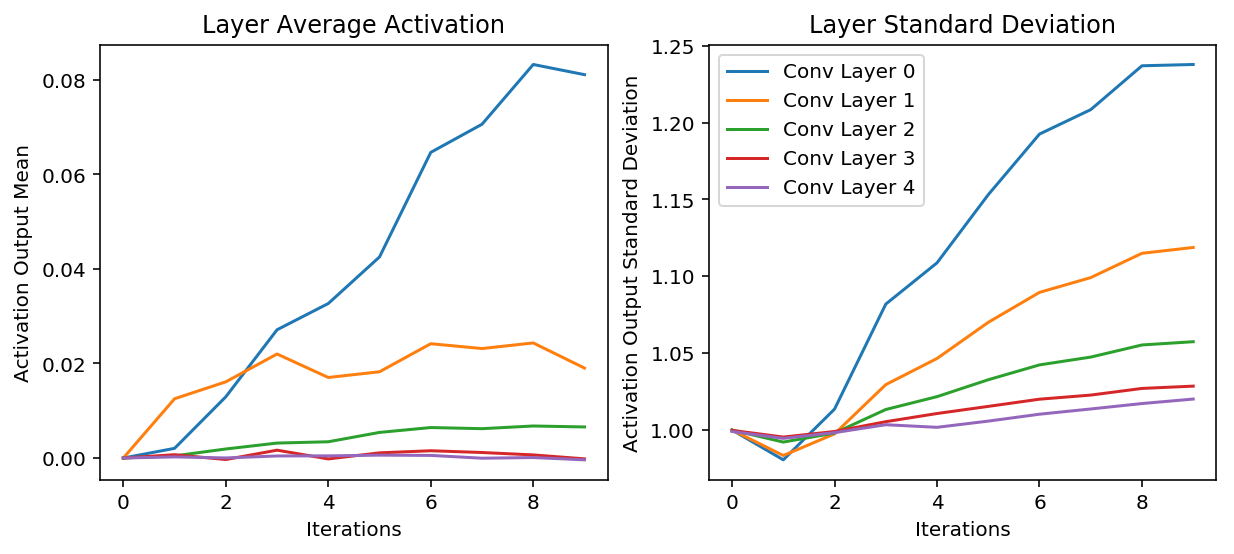

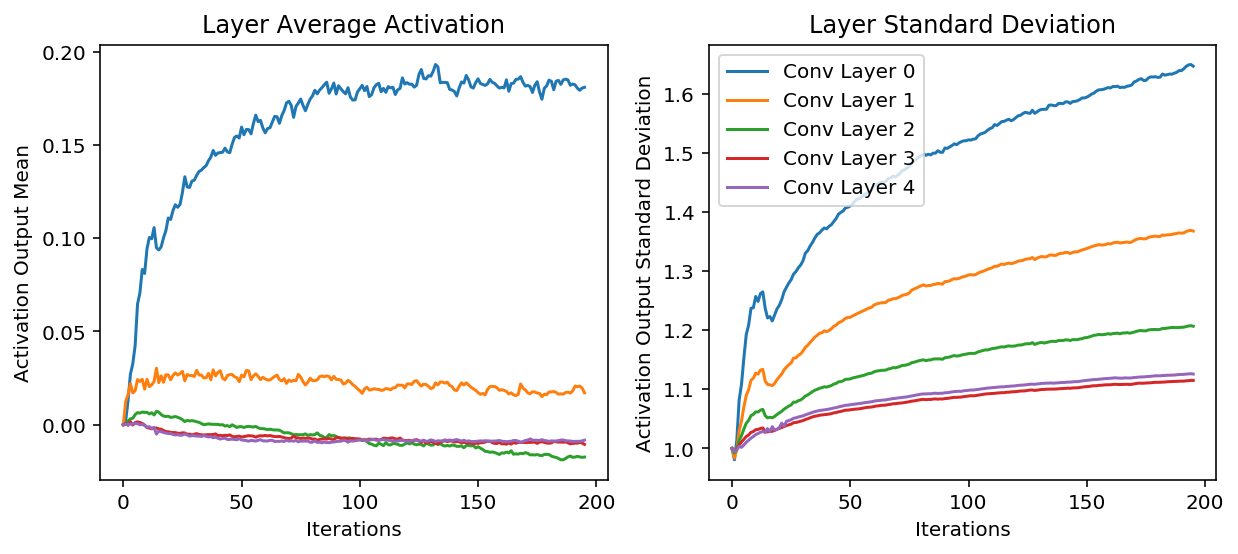

In [11]:
with ForwardHooks(learn.model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]: # Plot stats for the conv layers
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)])
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)]);

Two things immediately jump out to us:
1. The mean of activation outputs of all convolutional layers are indeed quite close to zero -- much lower than what we saw in our most recent attempt at the [end of the previous notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/06_cuda_cnn_hooks_init_my_reimplementation.ipynb?flush_cache=true), where we weren't using batchnorm.
* Our layers also begin converging much earlier (within the first ten iterations), than before we started using batchnorm.

#### Using PyTorch's built-in batchnorm

Let's see how the performance of PyTorch's implementation of batchnorm compares to our home-grown attempt that we created above:

In [12]:
#export
def conv_layer(n_in, n_out, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(n_out, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [13]:
learn, run = get_learn_run(n_outs, data, 1., conv_layer, cbs=cbfs)

In [14]:
%time run.fit(2, learn)

train: [0.27527091796875, tensor(0.9162, device='cuda:0')]
valid: [0.11195841064453126, tensor(0.9636, device='cuda:0')]
train: [0.0769994873046875, tensor(0.9761, device='cuda:0')]
valid: [0.0893177001953125, tensor(0.9733, device='cuda:0')]
CPU times: user 2.98 s, sys: 607 ms, total: 3.59 s
Wall time: 3.59 s


Great! The results are more or less identical to what we got with our own version of batchnorm!

#### Coup de grâce: use cosine annealing to warm-up & cool-down the learning rate

In [15]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.6, 2.), sched_cos(2., 0.1)])

In [16]:
learn, run = get_learn_run(n_outs, data, 1.0, conv_layer, cbs=cbfs + 
                          [partial(ParamScheduler, 'lr', sched)])

In [17]:
run.fit(8, learn)

train: [0.3108619921875, tensor(0.9092, device='cuda:0')]
valid: [0.13073406982421876, tensor(0.9568, device='cuda:0')]
train: [0.0978476953125, tensor(0.9693, device='cuda:0')]
valid: [0.105188916015625, tensor(0.9687, device='cuda:0')]
train: [0.0628054345703125, tensor(0.9803, device='cuda:0')]
valid: [0.06842420654296875, tensor(0.9795, device='cuda:0')]
train: [0.04291349609375, tensor(0.9867, device='cuda:0')]
valid: [0.06778866577148437, tensor(0.9809, device='cuda:0')]
train: [0.02757402587890625, tensor(0.9912, device='cuda:0')]
valid: [0.0472507080078125, tensor(0.9850, device='cuda:0')]
train: [0.016662178955078124, tensor(0.9951, device='cuda:0')]
valid: [0.03581134948730469, tensor(0.9894, device='cuda:0')]
train: [0.00992721435546875, tensor(0.9978, device='cuda:0')]
valid: [0.03701351623535156, tensor(0.9891, device='cuda:0')]
train: [0.007363419799804687, tensor(0.9986, device='cuda:0')]
valid: [0.036390802001953125, tensor(0.9887, device='cuda:0')]


Quite impressive: by using batchnorm and cosine warm-up/annealing for our learning cycle we've achieved a validation accuracy near `99%`!

### Batchnorm's achilles heel: small batch sizes

Batchnorm's effectiveness is dependent on mini-batch size. If batch-size is extremely small, there likely isn't be much benefit to using batchnorm. In fact, using batchnorm would likely do more harm than good. To see why, first imagine what would happen if we had a batch size of 1: the variance of this batch would be zero, since the value of the item and the mean of the batch are both the same.

Now imagine what would happen if we had a batch of size 2 or 3: while there may not be a 100% chance of getting a variance of 0 for the batch, it's conceivable that there may be batches where all items *do* have the same or nearly similar values, resulting in a variance of 0 or close to it. If this kind of batch were to occur several batches into training, the moving average of variance used to normalize layer inputs would possibly abruptly drop to too low a value, causing layer inputs to be "normalized" to values that are too high, which would have the consequence of requiring a longer duration for successful training to occur.

Unfortunately, there is the far more dire scenario in which the first mini-batch has a variance of zero. And there is the real chance that if this were the case, that training would completely fail. The denominator of the batchnorm algorithm would be too small, which would cause the batchnormed outputs (which in turn become the next layer's input values) to be extremely large. The effects of this explosion would likely ripple on down through the rest of the network, and there is the real chance that parameter weights may never be able to adjust to the extent necesary to compensate for this. At the very least, it's easy to imagine that the length of time necessary for the model to successfully train would be significantly extended.

One technicality is that thanks to the presence of the $\epsilon$ hyperparameter alongside the variance term in the denominator, even if the first mini-batch's variance were 0, we wouldn't actually be dividing by zero if we were to try to normalize this batch. Nonetheless, since $\epsilon$ is still quite small, the result would be nearly as useless: the next layer's input values would all be "normalized" to extremely large values, and the consequences described above would occur all the same.

Here's a simple example that depicts the kind of "worst case scenario" where batch norm will fail us:

In [49]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs=2), c)

def conv_layer(n_in, n_out, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(n_out, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

learn, run = get_learn_run(n_outs, data, 0.4, conv_layer, cbs=cbfs)

train: [2.33529984375, tensor(0.1698, device='cuda:0')]
valid: [8.61456015625, tensor(0.2227, device='cuda:0')]


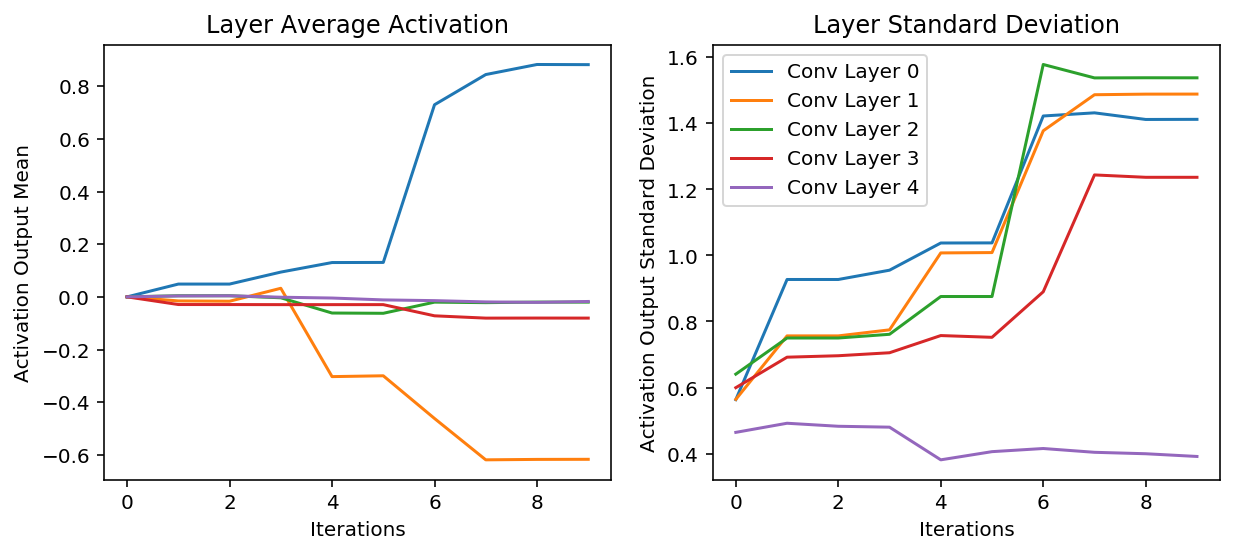

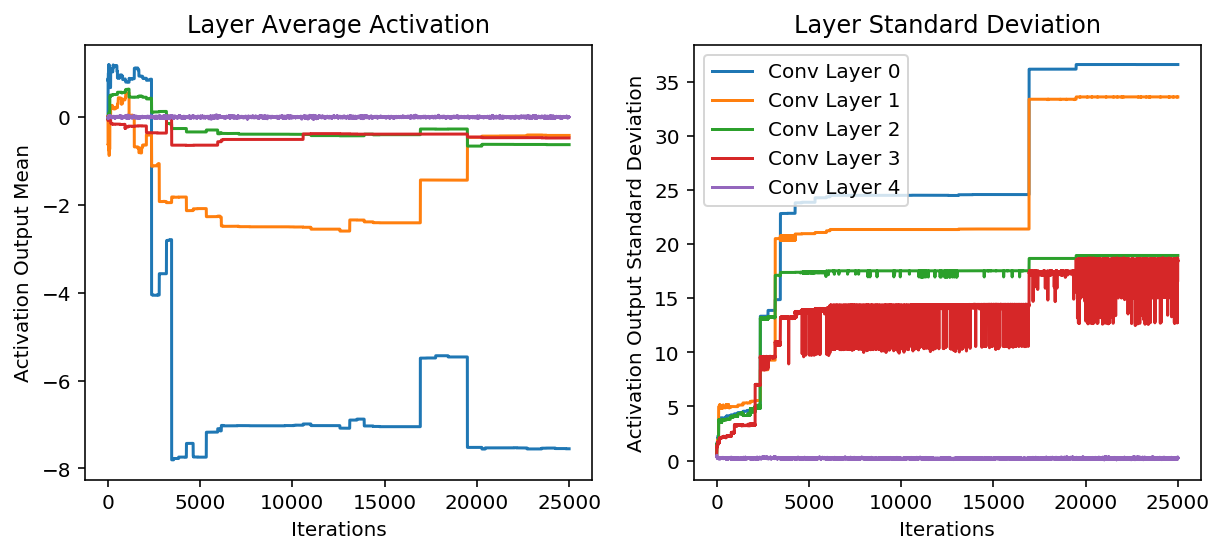

In [51]:
with ForwardHooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]: # Plot stats for the conv layers
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)])
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)]);

The gist of it is this: with a batch size of 2, our CNN's layers appear to start to converge within the first couple of iterations, but then the outputs of lower layers start to explode while those of the final convolutional layer stay flatlined throughout all iterations. It's clear that if the network ever does begin to learn to classify MNIST images, it would take quite some time.

### Other norms I: Layer Norm

Layer norm, [created by Jimmy Ba et. al. in 2016](https://arxiv.org/abs/1607.06450) was devised as a workaround to batchnorm's vulnerability with small batch sizes. While layer norm does normalize layer inputs, unlike batchnorm, it does this using a mean and variance that is computed over the hidden (or channel), height, and width dimensions of one sample, e.g. one image, at a time.

This means that there is no need to keep tabs on updating moving averages of layer mean/variance from batch to batch. Additionally, the layer-norm calculation behaves the same, regardess of whether the layer is receiving its input during training or during inference.

However, layer norm is not without its own achilles heel. Because layer-norm normalizes inputs on a sample-by-sample basis, it results in a network with layers that are unable to tell the difference between inputs that cause layers be normalized in the same way, but are qualitatively distinct, themselves.

Here's a concrete example: imagine that you have a dataset that contains several images of the sky. Some of these images consist entirely of a clear-blue sky on a sunny day -- the entire image is blue. Other images consist of a cloudy-gray sky on a dismal day -- the entire image is gray. Observe that the values inside each image are in similarly narrow ranges: the blue-sky image's "blue" values are within as narrow a range of "blueness" as the gray-fog images's "gray" values are in a range of grayness. 

The moral of the story is that the two images, though different, have very similar variances. And the similarity of these variances would cause layer norm to re-jigger (normalize) layer inputs for each of these images in a way that is far too similar to do justice to the very different qualitative natures of these images (all blue vs. all gray).

The long and short of it is that layer norm works well when you care about the variation *inside* each of your model inputs (e.g. pictures containing objects or animals, etc.). However, in cases where you wish to distinguish based on the *overall qualities*, in other words, on overall activation values (e.g. different images of solid colors), layer norm will not be helpful as it treats such inputs as if they were identical.

In [18]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        # For layer-norm calculate mean and variance 
        # for each individual input image (over the
        # hidden, or channel, dimension) across height 
        # and width.
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x - m) / ((v + self.eps).sqrt())
        return x * self.mult + self.add

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [19]:
def conv_layer_LN(n_in, n_out, ks=3, stride=2, ln=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if ln: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [20]:
learn, run = get_learn_run(n_outs, data, 1.0, conv_layer_LN, cbs=cbfs)

train: [nan, tensor(0.1179, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


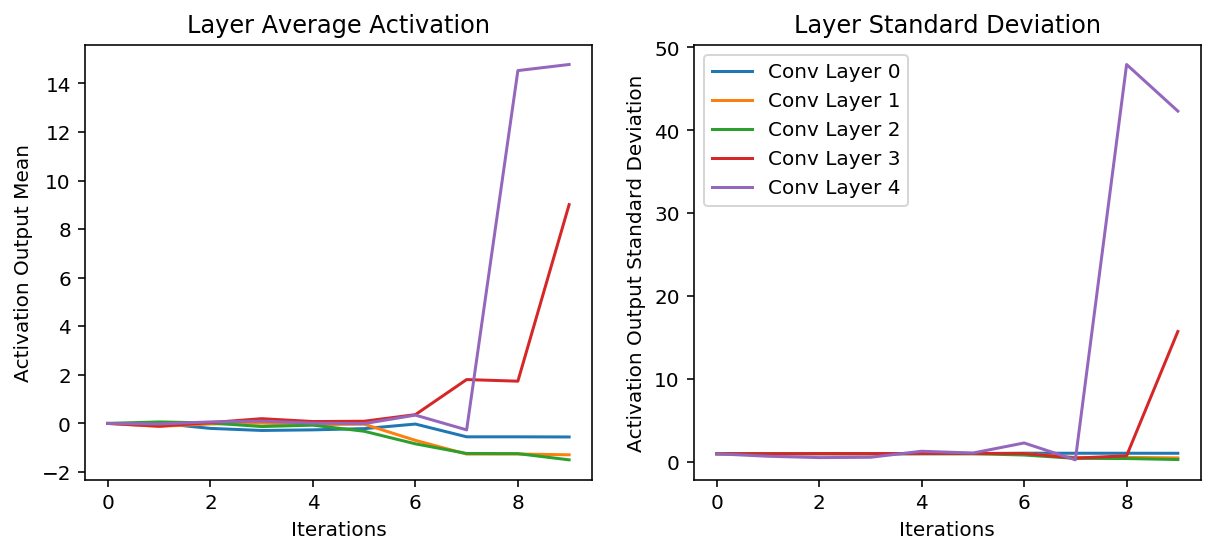

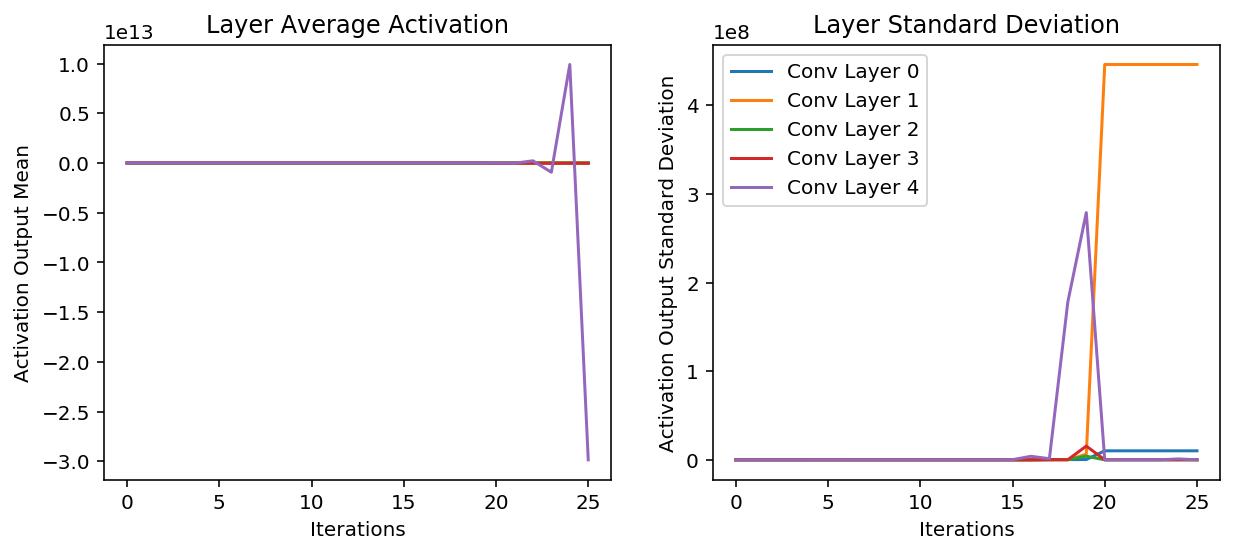

In [21]:
with ForwardHooks(learn.model, append_stats) as hooks:
    run.fit(3, learn)
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]: # Plot stats for the conv layers
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)])
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:5]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Conv Layer {i}' for i in range(5)]);

To say that Label Norm doesn't work that great for the MNIST dataset would be a colossal understatement -- we can see that outputs of all convolutional layers explode outside the ideal range of [-1, 1] beginning around the 7th iteration. The outputs of the 5th layer explode to a bonkers thirteen degrees of magnitude by the 25th iteration. This why our model's loss is so large that the computer can't store it as a number.

### Other norms II: Instance Norm

Also in 2016, [Ulyanov, Vedaldi, and Lempitsky proposed](https://arxiv.org/abs/1607.08022) another normalization method called Instance Normalization, which is identical to layer norm, except that it  omits the hidden, or channel, dimension and normalizes layer inputs on a per-sample basis by calculating mean and variance across just the height & width dimensions of each input sample/image.

Instance norm was intended to aid in style transfer applications, and similar to how layer norm throws away too much information to be useful in general image classification applications, we'll see that instance norm performs similarly poorly on the MNIST task:

In [22]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, n_out, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (n_out,1,1))
        self.adds  = nn.Parameter(torch.zeros(n_out,1,1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x - m) / ((v + self.eps).sqrt())
        return res * self.mults + self.adds

In [23]:
def conv_layer_IN(n_in, n_out, ks=3, stride=2, instance_norm=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if instance_norm: layers.append(InstanceNorm(n_out))
    return nn.Sequential(*layers)

In [24]:
learn, run = get_learn_run(n_outs, data, 0.1, conv_layer_IN, cbs=cbfs)

In [25]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 6.07 s, sys: 1.22 s, total: 7.29 s
Wall time: 7.29 s


### Other norms III: Group Norm

Before we wrap up we'll explore one more alternative to batchnorm: [proposed by Yuxin Wu and Kaiming He in 2018](https://arxiv.org/pdf/1803.08494.pdf), Group Norm groups the channels in an input image's hidden/channels dimension into a pre-determined number of groups where each group contains an equal proportion of channels. The mean and variance across height/width of an image are computed for each group of channels. These per-channel-group mean & variance values are used to normalize layer inputs on a per input image basis, similar to layer norm.

The group norm paper has this helpful diagram to help us visualize how normalization approaches differ:


![Various norms](images/norms.png)

Since our MNIST input images have only 1 channel, it should be obvious that if we used Group Norm, we'd be correspondingly limited a group size of 1. This, in turn, would make for a normalization scheme identical to layer norm. And since we saw just above how poorly layer norm worked for MNIST inputs, Group Norm definitely wouldn't be the first method we'd wanna try out. Nonetheless, let's use [PyTorch's GroupNorm()](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) implementation to verify that performance will be as poor as we expect:

In [33]:
def conv_layer_GN(n_in, n_out, ks=3, stride=2, group_norm=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if group_norm: layers.append(GroupNorm(num_groups=1, num_channels=n_in))
    return nn.Sequential(*layers)

In [34]:
learn, run = get_learn_run(n_outs, data, 1.0, conv_layer_IN, cbs=cbfs)

In [35]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.98 s, sys: 1.31 s, total: 7.29 s
Wall time: 7.29 s


Yep, validation accuracy is identical to what we saw with layer norm!

### Running BatchNorm: A better approach to solving batchnorm's achilles heel

In [lesson 10](https://youtu.be/HR0lt1hlR6U) of the 2019 [fast.ai](https://www.fast.ai/) Deep Learning from Foundations course, we learned of a new technique developed by [Jeremy Howard](https://www.fast.ai/about/#jeremy) and [Sylvain Gugger](https://www.fast.ai/about/#sylvain) called Running Batch Norm. It also attempts to workaround the small batch size vulnerability, but by using a *smoother* running mean and variance:

In [72]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, n_out, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (n_out,1,1))
        self.adds  = nn.Parameter(torch.zeros(n_out,1,1))
        self.register_buffer('sums', torch.zeros(1,n_out,1,1))
        self.register_buffer('sqrs', torch.zeros(1,n_out,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor',tensor(0.))
        self.register_buffer('offset',tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1 - self.mom) / math.sqrt(bs - 1))
        self.sums .lerp_(s , mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c , mom1)
        self.batch += bs
        means = self.sums / self.count
        variances = (self.sqrs / self.count).sub_(means * means)
        if bool(self.batch < 20): variances.clamp_min_(0.01)
        self.factor = self.mults / (variances + self.eps).sqrt()
        self.offset = self.adds - means * self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x * self.factor + self.offset

Note that the initial version of running batch norm de-biased the sums, squares, and counts inside the class' `forward()` method:
```python
if self.step<100:
    sums = sums / self.dbias
    sqrs = sqrs / self.dbias
    c    = c    / self.dbias
```
Although everyone's hearts were certainly in the right place, [Tom Viehmann]() from the PyTorch team noticed that dividing a de-biased sum by a de-biased count gives the same result as dividing a biased sum by a biased count. Tom also suggested using `factor` and `offset` for the final calculation as this would reduce broadcasting. Previously the calculation looked like:
```python
x = (x-means).div_((vars.add_(self.eps)).sqrt())
return x.mul_(self.mults).add_(self.adds)
```
Finally, [Stas Bekman](https://forums.fast.ai/u/stas/summary) also suggested saving `eps` as a buffer since this value impacts the calculation.

Let's take our Running Batch Norm out for a spin and see how it fares with using our MNIST data with a batch size of 2:

In [73]:
def conv_layer_RBN(n_in, n_out, ks=3, stride=2, rbn=True, **kwargs):
    layers = [nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride, bias=not rbn),
              GeneralRelu(**kwargs)]
    if rbn: layers.append(RunningBatchNorm(n_out))
    return nn.Sequential(*layers)

In [74]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs=2), c)

In [75]:
learn, run = get_learn_run(n_outs, data, 0.4, conv_layer_RBN, cbs=cbfs)

In [76]:
%time run.fit(1, learn)

train: [0.4725688671875, tensor(0.8737, device='cuda:0')]
valid: [0.19239730224609375, tensor(0.9607, device='cuda:0')]
CPU times: user 3min 27s, sys: 1.22 s, total: 3min 29s
Wall time: 3min 29s


Amazing! Running batch norm enables by far and away the best performance (compared to layer norm, instance norm, and group norm) when training on MNIST with a small batch size. We get a validation accuracy of `96%` after one epoch!

Let's increase our batch size to a more reasonable size of 64 and double check that running batch norm still works well. We'll use the cosine warm-up and annealing learning rate scheduler that we defined earlier:

In [77]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs=64), c)

In [78]:
learn, run = get_learn_run(n_outs, data, 1., conv_layer_RBN, cbs=cbfs + 
                           [partial(ParamScheduler, 'lr', sched)])

In [79]:
%time run.fit(1, learn)

train: [0.163569970703125, tensor(0.9497, device='cuda:0')]
valid: [0.05061226501464844, tensor(0.9860, device='cuda:0')]
CPU times: user 7.34 s, sys: 112 ms, total: 7.45 s
Wall time: 7.48 s


Looks great -- a near `99%` validation accuracy score after one epoch! With standard batch norm, and under the same learning rate scheduling regime, it took us about 8 epochs to get to this level.

### Export

In [80]:
nb_auto_export()

<IPython.core.display.Javascript object>